In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras import regularizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from sklearn import preprocessing

With the help of TrainingHistory we can easily retrieve important pieces of information in connection with the learning process.

In [0]:
class TrainingHistory(Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = [] #training loss
        self.valid_losses = [] #validation loss
        self.epoch = 0 # number of epochs
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.epoch += 1
            
history = TrainingHistory()

I built the model corresponding to the one mentioned in this article:
https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XL-2-W3/219/2014/isprsarchives-XL-2-W3-219-2014.pdf. I used momentum method in order not to get stucked in local minima, and I adjusted a quite big learning rate.

In [0]:
model = Sequential()
model.add(Dense(10, input_shape=(7,), activity_regularizer=regularizers.l1(0.01)))
model.add(Activation("tanh"))
model.add(Dense(15, activity_regularizer=regularizers.l1(0.01)))
model.add(Activation("tanh"))
model.add(Dense(1, activity_regularizer=regularizers.l1(0.01)))
model.add(Activation("tanh"))
model.compile(loss='mean_squared_error', optimizer= SGD(lr=5, momentum=0.001, nesterov=True))

I created the data files by copying and pasting the content of the tables on this webpage (not so elegant method, but the lack of time forced me to act like this):
http://idojarasbudapest.hu/archivalt-idojaras. 
I got 270 records (data corresponding to 9 months in 2019).
The function defined below reads a datafile into a dataframe, computes the average temperature for every record and removes the irrelevant columns.

In [0]:
def preproc(filename):
    df=pd.read_csv("./"+filename, sep='\t',header=None,  names=["day", "min", "max", "wind", "rain"]).dropna()
    df=df.drop(columns=["day", "wind", "rain"])
    df["avg"]=0.5*(df["min"]+df["max"])
    df=df.drop(columns=["min", "max"])
    return df

I worked in Google Colab, so the data files had to be uploaded to the cloud.

In [0]:
from google.colab import files
files.upload()

I read all the files and concatenated the content of them into one dataframe.

In [0]:
data=pd.DataFrame({"avg": []})
for i in range(9):
    filename="data%d"%(i+1)
    df=preproc(filename)
    data=pd.concat([data, df])
    
data=data.set_index(np.linspace(1, 270, 270))

I supposed that the average temperature of each and every day is determined by the temperatures of the week that the given day follows, so with this assumption an input record which will be fed into the neural network consists of 7 temperatures measured on 7 consecutive days and a target temperature which is the temperature of the following day. In order to generate the training database I took the dataframe consisting of 270 rows, duplicated and shifted it by 1 row and put the newly created column next to the original one. I repeated this methodology seven times. Of course after that I dropped the NaN values from the resulting dataframe.

In [0]:
data=data.rename(columns={"avg":"avg1"})
aux_old=pd.DataFrame(data["avg1"].shift(-1, axis=0))
aux_old=aux_old.rename(columns={"avg1":"avg2"})
data=pd.concat([data, aux_old], axis=1)
for i in range(6):
    aux_old=aux_old.rename(columns={"avg%d"%(i+2):"avg%d"%(i+3)})
    aux_new=pd.DataFrame(aux_old["avg%d"%(i+3)].shift(-1, axis=0))
    data=pd.concat([data, aux_new], axis=1)
    aux_old=aux_new

In [0]:
data=data.dropna()

In [60]:
data

,avg1,avg2,avg3,avg4,avg5,avg6,avg7,avg8
1.0,0.15,7.40,7.25,2.65,1.65,-0.75,-1.65,-0.35
2.0,7.40,7.25,2.65,1.65,-0.75,-1.65,-0.35,0.05
3.0,7.25,2.65,1.65,-0.75,-1.65,-0.35,0.05,0.90
4.0,2.65,1.65,-0.75,-1.65,-0.35,0.05,0.90,4.30
5.0,1.65,-0.75,-1.65,-0.35,0.05,0.90,4.30,1.25
...,...,...,...,...,...,...,...,...
259.0,17.65,17.75,17.50,18.90,19.60,19.35,19.75,18.45
260.0,17.75,17.50,18.90,19.60,19.35,19.75,18.45,18.30
261.0,17.50,18.90,19.60,19.35,19.75,18.45,18.30,16.70
262.0,18.90,19.60,19.35,19.75,18.45,18.30,16.70,17.00


The records of the dataframe are converted to named tuples, and the table is partitioned into train, test and validation sets. The database is also standardised.

In [92]:
nb_samples=263
valid_split = 0.2
test_split = 0.1
samples=np.zeros(nb_samples, dtype=[('input', float, 7), ('output', float, 1)])
for i in range(nb_samples):
  samples[i] = tuple(data.loc[i+1, "avg1":"avg7"]), data.loc[i+1, "avg8"]

samples_train = samples[0:int(nb_samples*(1-valid_split-test_split))]
samples_valid = samples[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
samples_test  = samples[int(nb_samples*(1-test_split)):]
# standardisation besides taking into account that the standardising coefficients shall be derived only from the training data
scaler = preprocessing.StandardScaler().fit(samples_train['input'])
samples_train['input'] = scaler.transform(samples_train['input'])
samples_valid['input'] = scaler.transform(samples_valid['input'])
samples_test['input'] = scaler.transform(samples_test['input'])

samples_train['output'] = (samples_train['output']-np.mean(samples_train['output']))/np.std(samples_train['output'])
samples_valid['output'] = (samples_valid['output']-np.mean(samples_train['output']))/np.std(samples_train['output'])
samples_test['output'] = (samples_test['output']-np.mean(samples_train['output']))/np.std(samples_train['output'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  after removing the cwd from sys.path.


Setting the parameters of early stopping.

In [0]:
from keras.callbacks import EarlyStopping
patience=10
early_stopping=EarlyStopping(patience=patience, verbose=1)

Specifying where to preserve the model corresponding to the minimum of the validation loss.

In [0]:
from keras.callbacks import ModelCheckpoint
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

The learning rate can be gradually shrinked during the learning process with the help of ReduceLROnPlateau.

In [0]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, min_lr=10e-5)

Training of the model. I adjusted the maximum number of epochs to 2500 and the batch size to 10. 

In [107]:
model.fit(samples_train['input'], samples_train['output'],
          batch_size=10,
          nb_epoch=2500,
          verbose=2, 
          validation_data=(samples_valid['input'],samples_valid['output']), 
          callbacks=[reduce_lr, checkpointer, early_stopping, history], 
          shuffle= True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 184 samples, validate on 52 samples
Epoch 1/2500
 - 1s - loss: 3730.5066 - val_loss: 4284.9757

Epoch 00001: val_loss did not improve from 471.80489
Epoch 2/2500
 - 0s - loss: 3853.9645 - val_loss: 4226.2973

Epoch 00002: val_loss did not improve from 471.80489
Epoch 3/2500
 - 0s - loss: 3787.7660 - val_loss: 4261.5583

Epoch 00003: val_loss did not improve from 471.80489
Epoch 4/2500
 - 0s - loss: 3763.6668 - val_loss: 4121.2038

Epoch 00004: val_loss did not improve from 471.80489
Epoch 5/2500
 - 0s - loss: 3699.8799 - val_loss: 4094.2077

Epoch 00005: val_loss did not improve from 471.80489
Epoch 6/2500
 - 0s - loss: 3659.0721 - val_loss: 4041.9552

Epoch 00006: val_loss did not improve from 471.80489
Epoch 7/2500
 - 0s - loss: 3635.1887 - val_loss: 4024.6802

Epoch 00007: val_loss did not improve from 471.80489
Epoch 8/2500
 - 0s - loss: 3575.2131 - val_loss: 3966.4570

Epoch 00008: val_loss did not improve from 471.80489
Epoch 9/2500
 - 0s - loss: 3596.8474 - val_loss: 39

We can visualize the learning process on a graph. It can be seen, that the training error shrinks down to near 0, but the validation loss reaches a minimum value much bigger than 0.

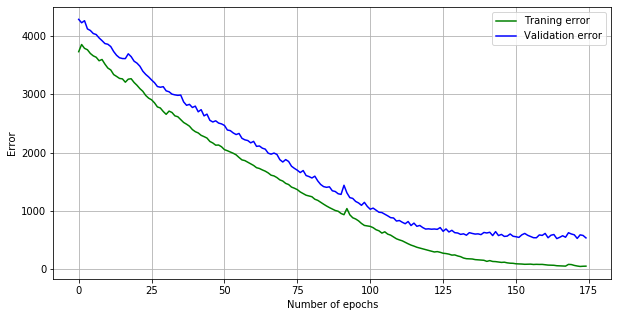

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Traning error') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Validation error')
plt.legend(loc='upper right')
plt.xlabel('Number of epochs')
plt.ylabel('Error')
plt.grid(True)
plt.show()

We can check the weight matrices. In my case this step was crucial because thanks to only this could I realize that L1 regularization was needed by the model to be able to learn.

In [109]:
i=0
for layer in model.layers:
    print(model.get_layer(index=i).get_weights())
    i=i+1

[array([[  77.89822  ,  -46.84957  ,    7.884418 ,   46.72828  ,
          -8.448791 ,    3.7370741,   50.66571  ,    3.3327181,
         -15.6357975,   11.264224 ],
       [  18.639694 ,   -0.9826864,  -41.609905 ,  -30.017012 ,
          42.857937 ,    4.8699117,   67.51755  ,    6.6646442,
          -8.844613 ,   -3.8475642],
       [ -32.637703 ,   30.340889 ,  -35.5329   ,  -62.142044 ,
          39.03556  ,   16.486284 ,   26.601519 ,  -10.617248 ,
          -7.14699  ,  -22.551708 ],
       [ 106.56044  , -110.018845 ,   91.36293  ,   48.513462 ,
         -90.19554  ,   -3.7700512,  -97.14733  ,    4.3850756,
          -7.098857 ,   16.39271  ],
       [  49.1121   ,  -60.4      ,   80.07217  ,   41.846626 ,
         -79.0322   ,  -15.988223 , -102.187874 ,    5.1325264,
           4.3661966,   15.671556 ],
       [ -79.85369  ,   70.82688  ,  -21.6604   ,  -39.15465  ,
          24.312761 ,   18.954956 ,    0.8218367,   -6.837497 ,
          -8.262513 ,   -5.6616087],
       [-

We can load the best model from the file weights.hdf5 and check its performance on the test data.

In [151]:
from keras.models import load_model
model = load_model('weights.hdf5')
preds=model.predict(samples_test['input'])
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(samples_test['output'],preds)
print("Test MSE: %f" % (test_mse))

Test MSE: 232.414815


Let's predict the average temperatures which will expectedly be measured on 30th October, 5th November and 26th November!

In [0]:
mu=np.mean(samples_train['output'])
sd=np.std(samples_train['output'])
steps_to_30_oct=2
steps_to_5_nov=8
steps_to_26_nov=29

In [0]:
samples2=samples

In [156]:
model.predict(samples_test['input'][:2])

array([[1.],
       [1.]], dtype=float32)

In [163]:
model.predict(np.array([1, 2, 3,4 , 5, 6, 7]).reshape((7,1)))

ValueError: ignored

In [172]:
model.predict(samples_test['input'][[0]])

array([[1.]], dtype=float32)

In [0]:
a=np.delete(samples_test['input'][[-1]], 0)

AttributeError: ignored